I. Import Packages

In [3]:
#Importing functions library

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

II. Creating Separate Functions for Airline Delay Prediction

In [4]:
# DONT REALLY UNDERSTAND THE CODE FOR THIS PART VERY WELL 
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [5]:
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [6]:
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

III. Data Wraggling for Flights Dataset

In [7]:
#Importing Flight dataset as flights_df

flights_df = pd.read_csv("Flights.csv")
flights_df.head(50)

# Changing Dates and Times YEAR MOTNH DAY
flights_df["DATE"] = pd.to_datetime(flights_df[["YEAR",'MONTH','DAY']])


In [8]:
# Information on raw data 
print(flights_df.columns)

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DATE'],
      dtype='object')


In [13]:
#Information on Column Types and No of Null Values
tab_info=pd.DataFrame(flights_df.dtypes).T.rename(index={0:'Column Type'})
tab_info=tab_info.append(pd.DataFrame(flights_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(flights_df.isnull().sum()/flights_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
Column Type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,datetime64[ns]
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640,0
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725,0


In [20]:
#Splitting data into 2 subsets - Arrival (arr_df) and Departure (dep_df)
arr_df = flights_df[['DATE','AIRLINE','TAIL_NUMBER','DESTINATION_AIRPORT','SCHEDULED_ARRIVAL', "ARRIVAL_TIME", "ARRIVAL_DELAY"]]
print(arr_df.head(3))
dep_df = flights_df[['DATE','AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', "DEPARTURE_DELAY"]]
print(dep_df.head(3))

#how come drop flight number? if flight number unique, link to origin and destination airport later?
#I feel the flight number is quite unique and there is little value to include it
#is flight number unique? if repeated - groupby?

        DATE AIRLINE TAIL_NUMBER DESTINATION_AIRPORT  SCHEDULED_ARRIVAL  \
0 2015-01-01      AS      N407AS                 SEA                430   
1 2015-01-01      AA      N3KUAA                 PBI                750   
2 2015-01-01      US      N171US                 CLT                806   

   ARRIVAL_TIME  ARRIVAL_DELAY  
0         408.0          -22.0  
1         741.0           -9.0  
2         811.0            5.0  
        DATE AIRLINE TAIL_NUMBER ORIGIN_AIRPORT  SCHEDULED_DEPARTURE  \
0 2015-01-01      AS      N407AS            ANC                    5   
1 2015-01-01      AA      N3KUAA            LAX                   10   
2 2015-01-01      US      N171US            SFO                   20   

   DEPARTURE_TIME  DEPARTURE_DELAY  
0          2354.0            -11.0  
1             2.0             -8.0  
2            18.0             -2.0  


In [30]:
#Data Cleaning for Flights for arr_df

# Removing the rows with null values (about 3% or 4% of all datapoint)
# Remove rows with missing "ARRIVAL_TIME" & "ARRIVAL_DELAY" from arr_df
arr_df = arr_df.dropna(axis = 0 , subset = ['ARRIVAL_TIME', 'ARRIVAL_DELAY'])

# Adding boolean column: Delay = 1, No delay (Early/Punctual) = 0
#cond_early_arr = arr_df["ARRIVAL_DELAY"] < 0
#cond_punctual_arr = arr_df['ARRIVAL_DELAY'] == 0
arr_df["DELAY"] = np.where(arr_df['ARRIVAL_DELAY'] <= 0, "0", "1")
arr_df.head()

,DATE,AIRLINE,TAIL_NUMBER,DESTINATION_AIRPORT,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DELAY
0,2015-01-01,AS,N407AS,SEA,430,408.0,-22.0,0
1,2015-01-01,AA,N3KUAA,PBI,750,741.0,-9.0,0
2,2015-01-01,US,N171US,CLT,806,811.0,5.0,1
3,2015-01-01,AA,N3HYAA,MIA,805,756.0,-9.0,0
4,2015-01-01,AS,N527AS,ANC,320,259.0,-21.0,0


In [29]:
#Data Cleaning for Flights for dep_df
dep_df = dep_df.dropna(axis = 0 , subset = ['DEPARTURE_TIME', 'DEPARTURE_DELAY'])

# Adding boolean column: Delay = 1, No delay (Early/Punctual) = 0
#cond_early_arr = arr_df["ARRIVAL_DELAY"] < 0
#cond_punctual_arr = arr_df['ARRIVAL_DELAY'] == 0
dep_df["DELAY"] = np.where(dep_df['DEPARTURE_DELAY'] <= 0, "0", "1")
dep_df.head()

#Will departure delay affect arrival delay? 
#Should we minus the departure delay from arrival delay to not double penalise the delay?
#That is a very good question but I am not too sure after we have removed them, how can we actually find out the difference between the flights that has arrival delay that is longer than the departure delay for the 
    #dataset right, it actually have one column named as arrival delay and the other named as departure delay

,DATE,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,DELAY
0,2015-01-01,AS,N407AS,ANC,5,2354.0,-11.0,0
1,2015-01-01,AA,N3KUAA,LAX,10,2.0,-8.0,0
2,2015-01-01,US,N171US,SFO,20,18.0,-2.0,0
3,2015-01-01,AA,N3HYAA,LAX,20,15.0,-5.0,0
4,2015-01-01,AS,N527AS,SEA,25,24.0,-1.0,0


In [18]:
#Convert the dataframe variables for this part 
arr_df['SCHEDULED_ARRIVAL'] = create_flight_time(arr_df, 'SCHEDULED_ARRIVAL')
arr_df['ARRIVAL_TIME'] = arr_df['ARRIVAL_TIME'].apply(format_heure)

arr_df.head()

#dep_df['DEPARTURE_TIME'] = dep_df['DEPARTURE_TIME'].apply(format_heure)
#dep_df['SCHEDULED_DEPARTURE'] = dep_df['SCHEDULED_DEPARTUREL'].apply(format_heure)

,DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,DESTINATION_AIRPORT,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DELAY
0,2015-01-01,4,AS,N407AS,SEA,2015-01-01 04:30:00,04:08:00,-22.0,0
1,2015-01-01,4,AA,N3KUAA,PBI,2015-01-01 07:50:00,07:41:00,-9.0,0
2,2015-01-01,4,US,N171US,CLT,2015-01-01 08:06:00,08:11:00,5.0,1
3,2015-01-01,4,AA,N3HYAA,MIA,2015-01-01 08:05:00,07:56:00,-9.0,0
4,2015-01-01,4,AS,N527AS,ANC,2015-01-01 03:20:00,02:59:00,-21.0,0


IV. Data Wraggling on Airports Dataset

In [21]:
# Importing airport dataset as airports_df
airports_df = pd.read_csv("airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


V. Data Wraggling on Airline Dataset

In [22]:
# Importing airlines dataset as airlines_df
airlines_df = pd.read_csv("airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


VI. Data Exploration on Flights CSV

In [23]:
# !! Proportion of delayed flights for arr_df
# Counting the number of flights per airline
arr_df_groupby_flights = arr_df.groupby("AIRLINE")
arr_df_flight_count = arr_df_groupby_flights.size().reset_index(name = "Number of Flights")
arr_df_flight_count

,AIRLINE,Number of Flights
0,AA,97549
1,AS,29614
2,B6,48157
3,DL,147486
4,EV,111206
5,F9,14669
6,HA,14133
7,MQ,65513
8,NK,19612
9,OO,107099


In [31]:
# Counting number of delays per airline
cond_arr_delay = arr_df["DELAY"] == "1"
arr_df_delay = arr_df[cond_arr_delay]
arr_df_delay_groupby_flights = arr_df_delay.groupby("AIRLINE")
arr_df_delay_count = arr_df_delay_groupby_flights.size().reset_index(name = "Number of Delay" )
arr_df_delay_count

,AIRLINE,Number of Delay
0,AA,39650
1,AS,9712
2,B6,21931
3,DL,48298
4,EV,47563
5,F9,8265
6,HA,6753
7,MQ,32444
8,NK,9727
9,OO,45636


In [32]:
# Calculating proportion of delay 
# No of delays/ No of flights per airline

by_airline = pd.merge(arr_df_flight_count, arr_df_delay_count)

by_airline["Proportion of Delay"] = arr_df_delay_count["Number of Delay"] / arr_df_flight_count["Number of Flights"]
by_airline


,AIRLINE,Number of Flights,Number of Delay,Proportion of Delay
0,AA,97549,39650,0.406462
1,AS,29614,9712,0.327953
2,B6,48157,21931,0.455406
3,DL,147486,48298,0.327475
4,EV,111206,47563,0.427702
5,F9,14669,8265,0.563433
6,HA,14133,6753,0.477818
7,MQ,65513,32444,0.495230
8,NK,19612,9727,0.495972
9,OO,107099,45636,0.426110


In [33]:
#Features of Cleaned Datasets 

# A) Arrival Delays - Data types, Dimension
print("Data Types:", arr_df.dtypes)
print("Dataframe Dimensions:", arr_df.shape)

Data Types: DATE                   datetime64[ns]
AIRLINE                        object
TAIL_NUMBER                    object
DESTINATION_AIRPORT            object
SCHEDULED_ARRIVAL               int64
ARRIVAL_TIME                  float64
ARRIVAL_DELAY                 float64
DELAY                          object
dtype: object
Dataframe Dimensions: (1005504, 8)


In [35]:
# Proportion of delayed flights for dep_df
# Counting the number of flights per airline
dep_df_groupby_flights = dep_df.groupby("AIRLINE")
dep_df_flight_count = dep_df_groupby_flights.size().reset_index(name = "Number of Flights")
dep_df_flight_count

,AIRLINE,Number of Flights
0,AA,92948
1,AS,29428
2,B6,45541
3,DL,144689
4,EV,105084
5,F9,14450
6,HA,14105
7,MQ,57999
8,NK,19164
9,OO,104294


In [36]:
# Counting number of delays per airline
cond_arr_delay = dep_df["DELAY"] == "1"
dep_df_delay = dep_df[cond_arr_delay]
dep_df_delay_groupby_flights = dep_df_delay.groupby("AIRLINE")
dep_df_delay_count = dep_df_delay_groupby_flights.size().reset_index(name = "Number of Delay" )
dep_df_delay_count

,AIRLINE,Number of Delay
0,AA,36591
1,AS,7751
2,B6,20184
3,DL,53842
4,EV,38200
5,F9,7146
6,HA,4248
7,MQ,27642
8,NK,8837
9,OO,36164


In [37]:
# Calculating proportion of delay 
# No of delays/ No of flights per airline

by_airline = pd.merge(dep_df_flight_count, dep_df_delay_count)

by_airline["Proportion of Delay"] = dep_df_delay_count["Number of Delay"] / dep_df_flight_count["Number of Flights"]
by_airline

,AIRLINE,Number of Flights,Number of Delay,Proportion of Delay
0,AA,92948,36591,0.393672
1,AS,29428,7751,0.263389
2,B6,45541,20184,0.443205
3,DL,144689,53842,0.372122
4,EV,105084,38200,0.363519
5,F9,14450,7146,0.494533
6,HA,14105,4248,0.301170
7,MQ,57999,27642,0.476594
8,NK,19164,8837,0.461125
9,OO,104294,36164,0.346751


In [38]:
#Features of Cleaned Datasets 

# A) Arrival Delays - Data types, Dimension
print("Data Types:", dep_df.dtypes)
print("Dataframe Dimensions:", dep_df.shape)

Data Types: DATE                   datetime64[ns]
AIRLINE                        object
TAIL_NUMBER                    object
ORIGIN_AIRPORT                 object
SCHEDULED_DEPARTURE             int64
DEPARTURE_TIME                float64
DEPARTURE_DELAY               float64
DELAY                          object
dtype: object
Dataframe Dimensions: (1009060, 8)


#### Exploratory Data Analysis

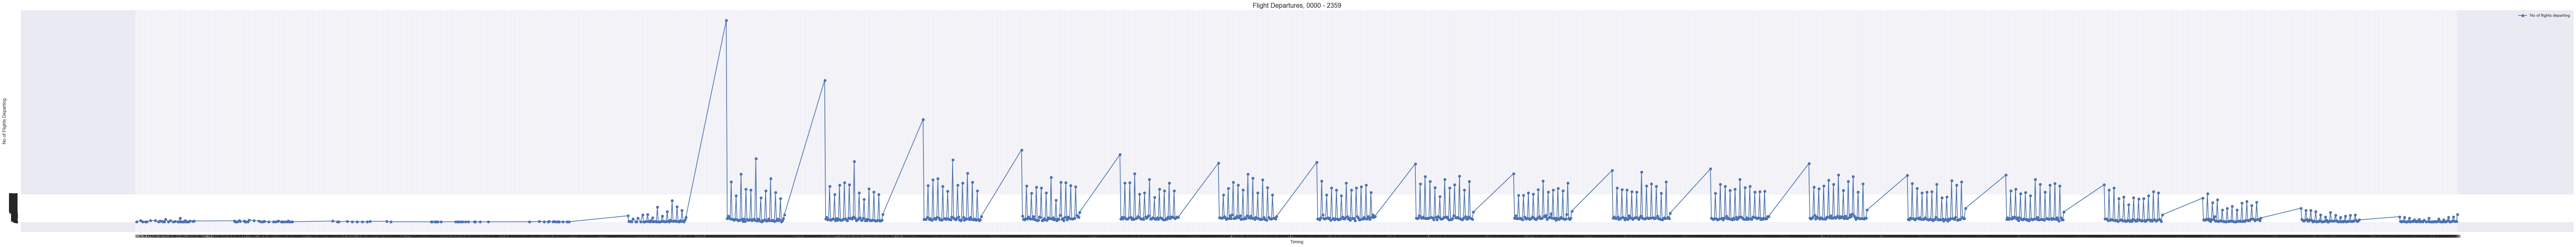

In [55]:
dep_df.head()
dep_timing = dep_df.groupby("SCHEDULED_DEPARTURE")
dep_timing_count = dep_timing.size().reset_index(name = "No of flights departing" )
dep_timing_count.head()

DIMS = (100,10)
sns.set()

fig = plt.figure(figsize = DIMS)
ax1 = fig.add_subplot(111)

ax1.set_title("Flight Departures, 0000 - 2359", fontsize = 16)
dep_timing_count.plot(kind = "line", 
                  x = 'SCHEDULED_DEPARTURE', 
                  y = 'No of flights departing', 
                  ax = ax1, 
                  marker = 'o'
)
plt.xticks(np.arange(0,2359))
plt.xlabel("Timing")

plt.yticks(np.arange(1,2815))
plt.ylabel("No of Flights Departing")
plt.show()

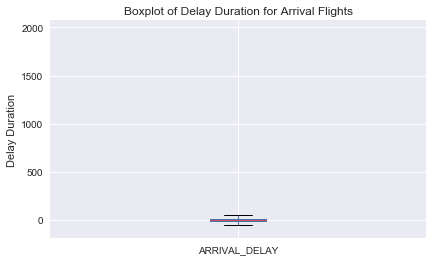

In [54]:
# BOXPPLOT TO SHOW Arrival Delay ATTRIBUTE DISTRIBUTION
fig, ax1 = plt.subplots()

arr_df["ARRIVAL_DELAY"].plot(kind = "box", ax = ax1)
ax1.set_ylabel("Delay Duration")
ax1.set_title("Boxplot of Delay Duration for Arrival Flights")
plt.show()

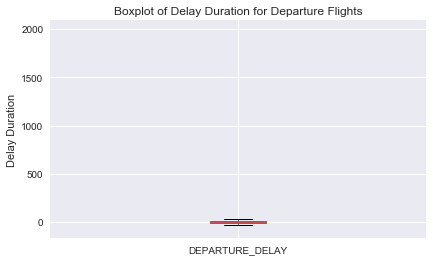

In [56]:
# Visualising the Number of Departure Delays in Boxplot
fig, ax2 = plt.subplots()
dep_df["DEPARTURE_DELAY"].plot(kind = "box", ax = ax2)
ax2.set_ylabel("Delay Duration")
ax2.set_title("Boxplot of Delay Duration for Departure Flights")
plt.show()

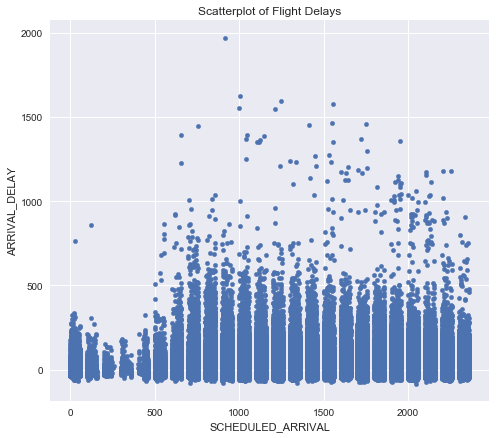

In [57]:
# Plot scatter plot for arr_df

fig, ax1 = plt.subplots()
arr_df.plot(
    kind='scatter', ax=ax1,
    title='Scatterplot of Flight Delays',
    x='SCHEDULED_ARRIVAL', y='ARRIVAL_DELAY',
    figsize=(7, 7),)
ax1.set_ylabel("ARRIVAL_DELAY")
plt.show()


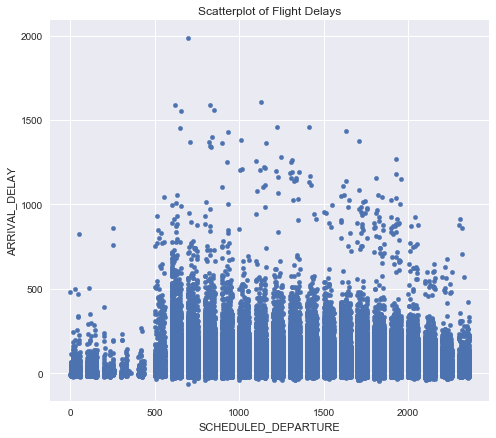

In [58]:
# Plot scatter plot for dep_df

fig, ax1 = plt.subplots()
dep_df.plot(
    kind='scatter', ax=ax1,
    title='Scatterplot of Flight Delays',
    x='SCHEDULED_DEPARTURE', y='DEPARTURE_DELAY',
    figsize=(7, 7),)
ax1.set_ylabel("ARRIVAL_DELAY")
plt.show()


In [ ]:
#analyse missing pattern - matplotlib 
#Removing Outliers for Arrival Delay

quartile_1 = np.percentile(arr_df["ARRIVAL_DELAY"],25) #cannot run the whole sample
quartile_3 = np.percentile(arr_df["ARRIVAL_DELAY"], 75)
print(quartile_1)
print(quartile_3)

iqr = quartile_3 - quartile_1
print(iqr)

lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

arr_df[(arr_df['ARRIVAL_DELAY'] < lower_bound) | (arr_df['ARRIVAL_DELAY'] > upper_bound)].sort_values(['ARRIVAL_DELAY'])

In [ ]:
#analyse missing pattern - matplotlib 
#Removing Outliers for Departure Delay

quartile_1 = np.percentile(dep_df["DEPARTURE_DELAY"],25) #cannot run the whole sample
quartile_3 = np.percentile(dep_df["DEPARTURE_DELAY"], 75)
print(quartile_1)
print(quartile_3)

iqr = quartile_3 - quartile_1
print(iqr)

lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

dep_df[(dep_df['DEPARTURE_DELAY'] < lower_bound) | (dep_df['DEPARTURE_DELAY'] > upper_bound)].sort_values(['DEPARTURE_DELAY'])

KeyError: 'AS'

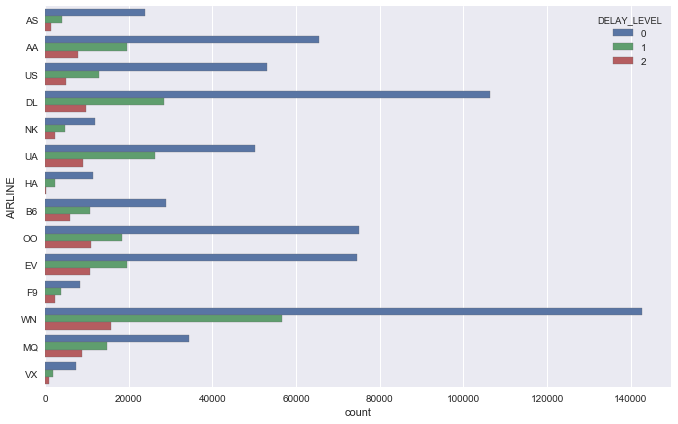

In [63]:
#Plotting the distribution of the flight count for delay for all airlines 
#Need to reformat the airline names
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
dep_df['DELAY_LEVEL'] = dep_df['DEPARTURE_DELAY'].apply(delay_type)

#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=dep_df)

# We replace the abbreviations by the full names of the companies and set the labels
labels = [airlines_df[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [ ]:
#Plotting the Delay Distribution Across All Airlines
#ERROR
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

In [75]:
#Plotting Delay Distribution Using b Parameter 
#Error
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________

# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(airlines_df)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

NameError: name 'points' is not defined

<Figure size 1100x500 with 0 Axes>

Overall EDA explore:
- Delay according flight timing (for both departure and arrival)
- the performance across the airlines based on delay
- the delay distribution across all airports on the map

##### Finding Relationship between Origin Airport and Departure Delays

In [73]:
dep_df_groupby_origin = dep_df.groupby('ORIGIN_AIRPORT')
dep_df_origin_count = dep_df_groupby_origin.size().reset_index(name = "No. of flights at Origin Airport")

cond_dep_delay = dep_df["DELAY"] == "1"
dep_df_delay = dep_df[cond_dep_delay]

dep_df_delay_groupby_origin = dep_df_delay.groupby("ORIGIN_AIRPORT")
dep_delay_origin_count = dep_df_delay_groupby_origin.size().reset_index(name = "No. of Flights Delayed at Origin Airport")

by_origin = pd.merge(dep_df_origin_count, dep_delay_origin_count, how = "inner", on = "ORIGIN_AIRPORT")
by_origin["Proportion of Flights Delayed at Origin Airport"] = by_origin["No. of Flights Delayed at Origin Airport"] / by_origin["No. of flights at Origin Airport"]
by_origin = by_origin.sort_values(by = "Proportion of Flights Delayed at Origin Airport", ascending = False)
by_origin.head()

,ORIGIN_AIRPORT,No. of flights at Origin Airport,No. of Flights Delayed at Origin Airport,Proportion of Flights Delayed at Origin Airport
240,PPG,21,13,0.619048
133,GUM,69,42,0.608696
299,TTN,491,296,0.602851
155,ISP,770,460,0.597403
307,UST,31,18,0.580645


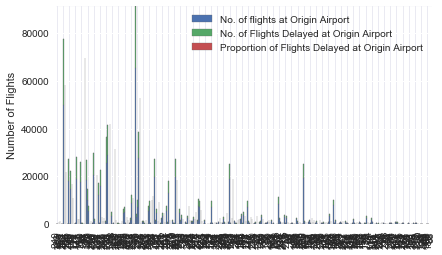

In [74]:
#Plotting stacked bars - number of flights and delays by origin airport

fig, ax1 = plt.subplots()
by_origin.plot(kind = "bar", 
               stacked = True, 
               ax = ax1

)

ax1.set_ylabel("Number of Flights")
plt.show()

In [76]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:,.2f}'.format
sns.set()

In [ ]:
model = sm.OLS(y,X)
trained_model = model.fit()
print(trained_model.summary())

#### Geographical Area Covered by Airlines

In [86]:
# Number of airports visited by each airline 
#airline: no of airports 

dep_df_airline_origin = dep_df.groupby(["AIRLINE", "ORIGIN_AIRPORT"]).size().reset_index()
dep_df_airline_origin.head()

#origin_nb = dict()
#for carrier in dep_airlines.key(): 
    #list_origin_airport = dep_df[dep_df["AIRLINE"]== carrier]["ORIGIN_AIRPORT"].unique()
    #origin_dict[carrier] = len(list_origin_airport)


,AIRLINE,ORIGIN_AIRPORT,0
0,AA,ABQ,283
1,AA,ATL,861
2,AA,AUS,1374
3,AA,BDL,187
4,AA,BHM,124


In [ ]:
airport_mean_delays = pd.Dataframe()